# RU-WRF 4.1: Create maps of % Cloud Cover

_Written by Lori Garzio, Aug 27, 2020_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook demonstrates how to access native model level data from the Rutgers University Weather Research and Forecasting Model (RU-WRF 4.1) from the [RUWRF THREDDs server](http://tds.marine.rutgers.edu/thredds/cool/ruwrf/catalog.html), subset the data for a specific time range and defined latitude/longitude grid, grab the cloud fraction (% cloud cover) at the low (300 m), mid (2000 m) and high (6000 m) levels, create a 4-panel plot for each hour output of the model, and save the plots to your local machine.

_**WARNING**: the model output is very large and these plots take several minutes to generate. Please restrict your time range to <24 hours to avoid crashing the THREDDs server._

In [1]:
# import the required packages for data access and plotting
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data Access

The RU-WRF 4.1 THREDDs server can be accessed [here](http://tds.marine.rutgers.edu/thredds/cool/ruwrf/catalog.html). For this example, we will be using the [Best](http://tds.marine.rutgers.edu/thredds/catalog/cool/ruwrf/wrf_4_1_3km_native_levels/catalog.html?dataset=cool/ruwrf/wrf_4_1_3km_native_levels/WRF_4.1_3km_Native_Levels_Dataset_Best) dataset from the WRF 4.1 3km Native Levels Dataset.

Once you've located the Best dataset and reviewed the documentation, you can access the data using Python via the Data URL found in the OPENDAP link. You will also need to specify: 

* the path to the local directory to which you want to save the plots
* the minimum and maximum latitude and longitudes you want to plot
* start and end times you want to subset to plot (**reminder**: keep to <24 hours)

_Some important information from the metadata page in the THREDDs server about time and geospatial coverage for this dataset:_

**Geospatial Coverage:**
* Longitude: -80.45 to -68.55 degrees_east
* Latitude: 34.32 to 43.15 degrees_north

**Start Time:** 2020-06-09T00:00:00Z

In [2]:
# data url
wrf_file = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/ruwrf/wrf_4_1_3km_native_levels/WRF_4.1_3km_Native_Levels_Dataset_Best'

# save file directory - change this to a local directory
save_dir = '/Users/lgarzio/Documents/rucool/tutorials'

# define the limits for the 3km model to subset and plot
# for this example we'll do just the Mid-Atlantic region
model_lims = dict(minlon=-79.9, maxlon=-69, minlat=34.5, maxlat=43)

# define the axis limits for plotting
axis_limits = [-79.7, -69.2, 34.5, 43]

# start and end times for plotting
start_time = dt.datetime(2020, 8, 4, 0, 0, 0)
end_time = dt.datetime(2020, 8, 4, 4, 0, 0)

Next, we'll use [xarray](https://pypi.org/project/xarray/) to open and subset the RU-WRF data file based on the date specified above.

In [3]:
# open the dataset
ds = xr.open_dataset(wrf_file, mask_and_scale=False)

# subset based on time
ds = ds.sel(time=slice(start_time, end_time))

# print the dataset to see the dimensions, coordinates, variables, etc
ds

<xarray.Dataset>
Dimensions:       (bottom_top: 47, low_mid_high: 3, south_north: 324, time: 5, west_east: 324)
Coordinates:
    XLONG         (south_north, west_east) float32 ...
    XLAT          (south_north, west_east) float32 ...
  * low_mid_high  (low_mid_high) int32 300 2000 6000
  * bottom_top    (bottom_top) int32 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45 46
  * time          (time) datetime64[ns] 2020-08-04 ... 2020-08-04T04:00:00
    time_run      (time) datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Data variables:
    temp          (time, bottom_top, south_north, west_east) float32 ...
    rh            (time, bottom_top, south_north, west_east) float32 ...
    height_msl    (time, bottom_top, south_north, west_east) float32 ...
    pressure      (time, bottom_top, south_north, west_east) float32 ...
    ter           (time, south_north, west_east) float32 ...
    slp           (time, south_north, west_east) float32 ...
    cloudfrac     (time, lo

In [4]:
# grab the time, latitude, and longitude variables
tm = ds['time']
lon = ds['XLONG']
lat = ds['XLAT']

# print the time variable - this subset contains data from within the requested timeframe
tm

<xarray.DataArray 'time' (time: 5)>
array(['2020-08-04T00:00:00.000000000', '2020-08-04T01:00:00.000000000',
       '2020-08-04T02:00:00.000000000', '2020-08-04T03:00:00.000000000',
       '2020-08-04T04:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2020-08-04 ... 2020-08-04T04:00:00
    time_run  (time) datetime64[ns] ...
Attributes:
    long_name:            Forecast time for ForecastModelRunCollection
    standard_name:        time
    missing_value:        nan
    _CoordinateAxisType:  Time

Next, we'll look at the latitude variable. Since latitude and longitude are 2D arrays we will need to geospatially subset the data by creating indices to use in the subsetting. We'll create those indices by finding where the latitude and longitude values are within the limits we defined above.

In [5]:
# 2D array
print('Latitude shape: {}'.format(np.shape(lat)))
lat.values

Latitude shape: (324, 324)


array([[34.321144, 34.32268 , 34.324215, ..., 34.324215, 34.32268 ,
        34.321144],
       [34.348   , 34.349537, 34.35108 , ..., 34.35108 , 34.349537,
        34.348   ],
       [34.37486 , 34.376396, 34.37794 , ..., 34.37794 , 34.376396,
        34.37486 ],
       ...,
       [42.95856 , 42.960304, 42.962032, ..., 42.962032, 42.960304,
        42.95856 ],
       [42.985413, 42.987152, 42.988888, ..., 42.988888, 42.987152,
        42.985413],
       [43.012268, 43.014008, 43.015747, ..., 43.015747, 43.014008,
        43.012268]], dtype=float32)

In [6]:
# create boolean indices where lat/lon are within defined boundaries
lon_ind = np.logical_and(lon > model_lims['minlon'], lon < model_lims['maxlon'])
lat_ind = np.logical_and(lat > model_lims['minlat'], lat < model_lims['maxlat'])

# print the lon_ind to see what the code above created
lon_ind

<xarray.DataArray 'XLONG' (south_north: 324, west_east: 324)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    XLONG    (south_north, west_east) float32 -79.76373 -79.7312 ... -68.55237
    XLAT     (south_north, west_east) float32 34.321144 34.32268 ... 43.012268
Dimensions without coordinates: south_north, west_east

In [7]:
# find i and j indices of lon/lat in boundaries
ind = np.where(np.logical_and(lon_ind, lat_ind))

Now, let's explore the cloud fraction data just at the first timestamp and subset the grid using the latitude/longitude index above.

In [8]:
# get the data for Cloud Fraction at the first timestamp in the time array
t = tm[0]  # grab the first timestamp
cloudfrac = ds.cloudfrac.sel(time=t.values)
print(cloudfrac)

<xarray.DataArray 'cloudfrac' (low_mid_high: 3, south_north: 324, west_east: 324)>
[314928 values with dtype=float32]
Coordinates:
    XLONG         (south_north, west_east) float32 -79.76373 ... -68.55237
    XLAT          (south_north, west_east) float32 34.321144 ... 43.012268
  * low_mid_high  (low_mid_high) int32 300 2000 6000
    time          datetime64[ns] 2020-08-04
    time_run      datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Attributes:
    units:          %
    long_name:      Cloud Area Fraction in Model Level
    _FillValue:     9.96921e+36
    description:    low, mid, high clouds
    low_thresh:     300.0 m
    mid_thresh:     2000.0 m
    high_thresh:    6000.0 m
    standard_name:  cloud_area_fraction_in_atmosphere_layer
    _ChunkSizes:    [  1   3 324 324]


Here we have cloud fraction at all of the model output latitude/longitude coordinates (indicated by the south_north and west_east dimensions) at 3 model levels (the low_mid_high dimension). You can see in the attributes that the "low" level = 300m, "mid" level = 2000m, and "high" level = 6000m. Let's look at that dimension more closely.

In [9]:
# look at the low_mid_high dimension
cloudfrac['low_mid_high']

<xarray.DataArray 'low_mid_high' (low_mid_high: 3)>
array([ 300, 2000, 6000], dtype=int32)
Coordinates:
  * low_mid_high  (low_mid_high) int32 300 2000 6000
    time          datetime64[ns] 2020-08-04
    time_run      datetime64[ns] ...
Attributes:
    units:                   m
    long_name:               Cloud Level
    comment:                 Cloud level, low 300 m, mid 2000 m, high 6000 m
    axis:                    Z
    positive:                up
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  up

This dimension allows us to subset the cloudfrac variable according to model level. Let's take a look at the cloudfrac data at just 300m.

In [10]:
cf300 = cloudfrac.sel(low_mid_high=300)
cf300

<xarray.DataArray 'cloudfrac' (south_north: 324, west_east: 324)>
[104976 values with dtype=float32]
Coordinates:
    XLONG         (south_north, west_east) float32 -79.76373 ... -68.55237
    XLAT          (south_north, west_east) float32 34.321144 ... 43.012268
    low_mid_high  int32 300
    time          datetime64[ns] 2020-08-04
    time_run      datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Attributes:
    units:          %
    long_name:      Cloud Area Fraction in Model Level
    _FillValue:     9.96921e+36
    description:    low, mid, high clouds
    low_thresh:     300.0 m
    mid_thresh:     2000.0 m
    high_thresh:    6000.0 m
    standard_name:  cloud_area_fraction_in_atmosphere_layer
    _ChunkSizes:    [  1   3 324 324]

In [11]:
# calculate % cloud cover from cloud fraction
cf300 = cf300 * 100
cf300

<xarray.DataArray 'cloudfrac' (south_north: 324, west_east: 324)>
array([[91.12048 , 92.313934, 91.6799  , ..., 56.88943 , 58.667725, 58.646698],
       [94.28253 , 96.52338 , 95.6012  , ..., 61.140198, 62.994843, 63.31345 ],
       [93.48779 , 95.80542 , 96.028534, ..., 65.2193  , 68.04184 , 67.42273 ],
       ...,
       [ 9.625366,  8.565521,  7.791229, ...,  0.      ,  0.      ,  0.      ],
       [12.441681, 11.525726, 10.880829, ...,  0.      ,  0.      ,  0.      ],
       [15.434204, 14.933655, 14.357178, ...,  0.      ,  0.      ,  0.      ]],
      dtype=float32)
Coordinates:
    XLONG         (south_north, west_east) float32 -79.76373 ... -68.55237
    XLAT          (south_north, west_east) float32 34.321144 ... 43.012268
    low_mid_high  int32 300
    time          datetime64[ns] 2020-08-04
    time_run      datetime64[ns] ...
Dimensions without coordinates: south_north, west_east

Let's subset the dataset using the lat/lon the index we created earlier.

In [12]:
# subset data from min i,j lat/lon corner to max i,j lat/lon corner
# there will be some points outside of defined boundaries because grid is not rectangular
cf300 = np.squeeze(cf300)[range(np.min(ind[0]), np.max(ind[0]) + 1), 
                          range(np.min(ind[1]), np.max(ind[1]) + 1)]
print(cf300)

lons = cf300['XLONG']
lats = cf300['XLAT']

<xarray.DataArray 'cloudfrac' (south_north: 320, west_east: 324)>
array([[ 93.48779 ,  95.80542 ,  96.028534, ...,  65.2193  ,  68.04184 ,
         67.42273 ],
       [ 93.41867 ,  93.55194 ,  94.38397 , ...,  68.69284 ,  71.17813 ,
         70.701385],
       [ 99.91525 , 100.      , 100.      , ...,  72.05817 ,  73.651794,
         73.09204 ],
       ...,
       [  4.534546,   3.031982,   1.703125, ...,   0.      ,   0.      ,
          0.      ],
       [  7.033478,   5.742706,   4.727844, ...,   0.      ,   0.      ,
          0.      ],
       [  9.625366,   8.565521,   7.791229, ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)
Coordinates:
    XLONG         (south_north, west_east) float32 -79.767456 ... -68.55716
    XLAT          (south_north, west_east) float32 34.37486 ... 42.95856
    low_mid_high  int32 300
    time          datetime64[ns] 2020-08-04
    time_run      datetime64[ns] ...
Dimensions without coordinates: south_north, west_east


## Generate Plots

Now that we've explored the data a bit and figured out how to subset the data we want, let's figure out how to make a plot for just one model level. After we do that successfully, we'll make a 4 panel plot with the 3 model levels plus Total Cloud Cover (defined as the maximum coverage of the three levels).

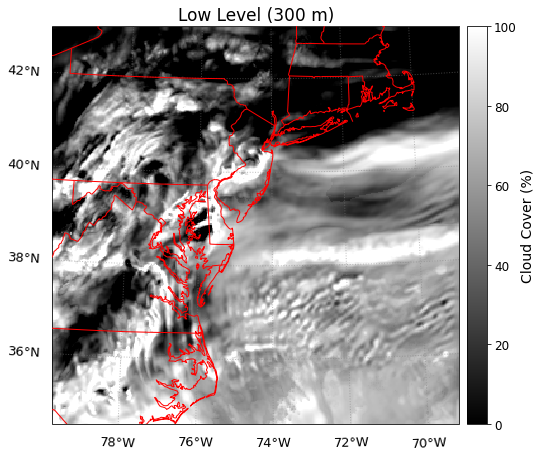

In [13]:
# set up the map
lccproj = ccrs.LambertConformal(central_longitude=-74.5, central_latitude=38.8)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=lccproj))

plt.subplots_adjust(right=0.88)  # adjust the right margin of the plot
plt.title('Low Level (300 m)', fontsize=17)  # add the title

# format the spacing of the colorbar
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)

# add the latitude and longitude gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, 
                  linestyle='dotted', x_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}
gl.xpadding = 12
gl.ypadding = 12

# specify the latitude and longitude gridlines and labels
gl.xlocator = mticker.FixedLocator([-78, -76, -74, -72, -70])
gl.ylocator = mticker.FixedLocator([36, 38, 40, 42])

# add map features
land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
ax.add_feature(land, zorder=5, edgecolor='red', facecolor='none')

state_lines = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

ax.add_feature(cfeature.BORDERS, zorder=6, edgecolor='red')
ax.add_feature(state_lines, zorder=7, edgecolor='red')

# set axis limits
ax.set_extent(axis_limits)

# plot the data
h = ax.pcolormesh(lons, lats, cf300.values, vmin=0, vmax=100, 
                  cmap='gray', transform=ccrs.PlateCarree())

# add the color bar
cb = plt.colorbar(h, cax=cax)
cb.set_label(label='Cloud Cover (%)', fontsize=14)  # add the label on the colorbar
cb.ax.tick_params(labelsize=12)  # format the size of the tick labels

# display the figure then close it
plt.show()
plt.close();

Now that we've successfully plotted one level, let's write a function that will populate a 4-panel plot with data from the 3 levels and total cloud fraction.

In [14]:
def plot_cloudfrac_panel(ax, plt_ttl, clabel, lon_data, lat_data, data, axlims, add_cbar):
    """
    Create a 4-panel pcolormesh surface map of cloud fraction
    ax: plotting axis to which the data are plotted
    plt_ttl: title for the plot
    clabel: label for the color bar
    lon_data: longitude data
    lat_data: latitude data
    data: variable data
    axlims: axis limits
    add_cbar: option to add the colorbar ('yes' or 'no')
    """
    ax.set_title(plt_ttl, fontsize=14)  # add the title

    # format the spacing of the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)

    # plot the data
    h = ax.pcolormesh(lon_data, lat_data, data, vmin=0, vmax=100, 
                      cmap='gray', transform=ccrs.PlateCarree())

    # add the color bar if indicated
    if add_cbar == 'yes':
        fig.add_axes(cax)
        cb = plt.colorbar(h, cax=cax)
        cb.set_label(label=clabel, fontsize=14)  # add the label on the colorbar
        cb.ax.tick_params(labelsize=12)  # format the size of the tick labels

    # add the latitude and longitude gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, 
                      linestyle='dotted', x_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.xpadding = 10
    gl.ypadding = 10
    
    # specify the latitude and longitude gridlines and labels
    gl.xlocator = mticker.FixedLocator([-78, -76, -74, -72, -70])
    gl.ylocator = mticker.FixedLocator([36, 38, 40, 42])
    
    # set axis limits
    ax.set_extent(axlims)

    # add map features
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    ax.add_feature(land, zorder=5, edgecolor='red', facecolor='none')

    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        edgecolor='red',
        facecolor='none')

    ax.add_feature(cfeature.BORDERS, zorder=6, edgecolor='red')
    ax.add_feature(state_lines, zorder=7)

Now, we need to loop through each of the timestamps, get the data for each of the levels and add it to the panels, and calculate Total Cloud Fraction and add that data to the bottom right panel.

Currently plotting: 2020-08-04 00:00


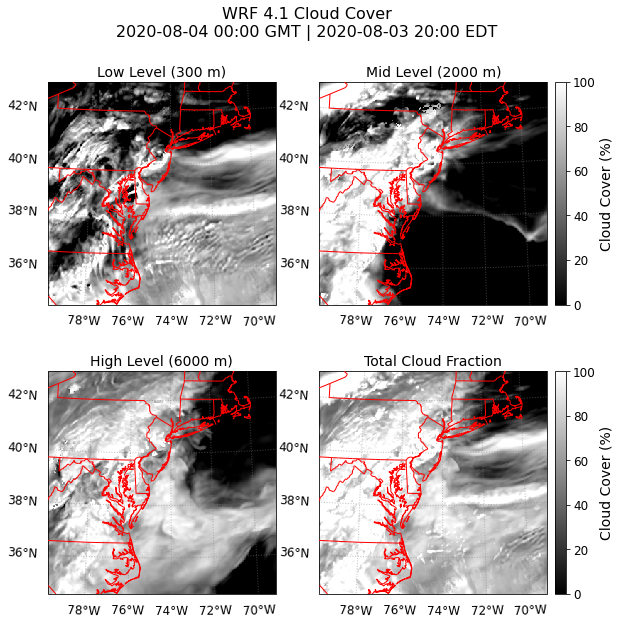

Currently plotting: 2020-08-04 01:00


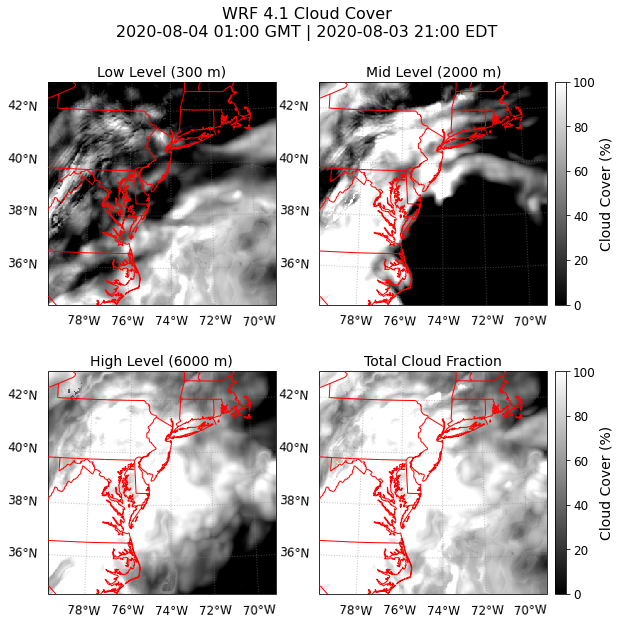

Currently plotting: 2020-08-04 02:00


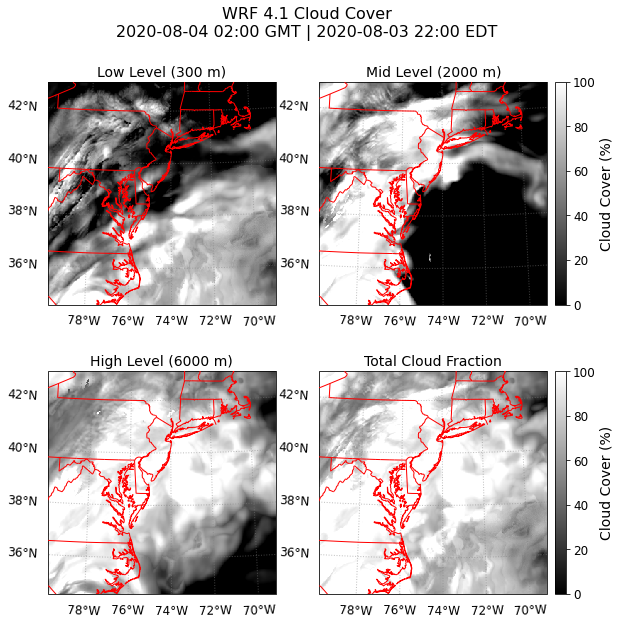

Currently plotting: 2020-08-04 03:00


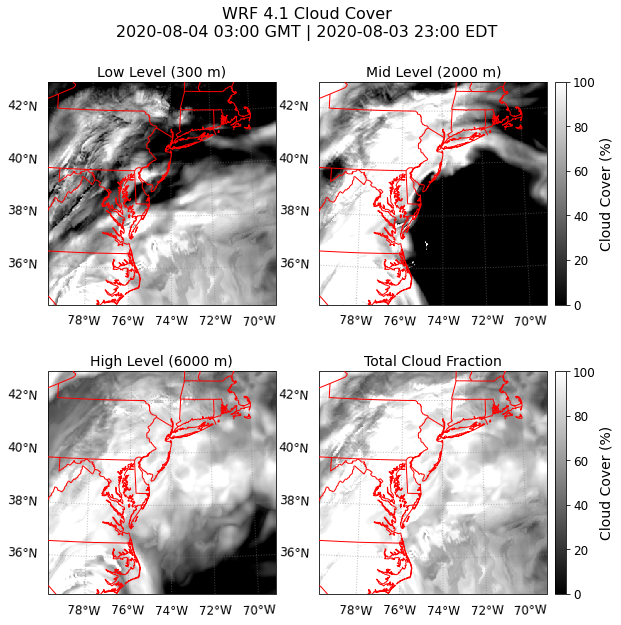

Currently plotting: 2020-08-04 04:00


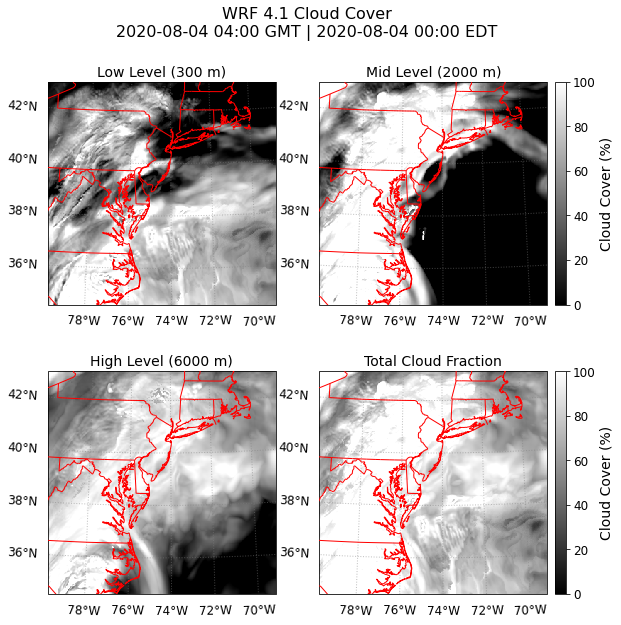

In [15]:
for t in tm:
    # set up a plot with 4 equal panels
    lccproj = ccrs.LambertConformal(central_longitude=-74.5, central_latitude=38.8)
    fig, axs = plt.subplots(2, 2, figsize=(9, 10), subplot_kw=dict(projection=lccproj), 
                            sharex=True, sharey=True)
    
    # get the data for cloud frac at the defined timestamp
    cloudfrac = ds.cloudfrac.sel(time=t.values)
    
    # subset data from min i,j lat/lon corner to max i,j lat/lon corner
    # there will be some points outside of defined boundaries because grid is not rectangular
    cloudfrac = np.squeeze(cloudfrac)[:, range(np.min(ind[0]), np.max(ind[0]) + 1), 
                                      range(np.min(ind[1]), np.max(ind[1]) + 1)]
    lons = cloudfrac['XLONG']
    lats = cloudfrac['XLAT']

    # calculate % cloud cover from cloud fraction
    cloudfrac = cloudfrac * 100
    
    # define labels for plot
    # convert timestamp to string
    timestr = dt.datetime.strftime(pd.to_datetime(t.values), '%Y-%m-%d %H:%M')
    print('Currently plotting: {}'.format(timestr))

    # convert time from GMT to EDT
    time_edt = pd.to_datetime(t.values) - dt.timedelta(hours=4)
    timestr_edt = dt.datetime.strftime(time_edt, '%Y-%m-%d %H:%M')  # convert timestamp to string

    # define plot title and color labels
    overall_title = 'WRF 4.1 Cloud Cover\n{} GMT | {} EDT'.format(timestr, timestr_edt)
    color_label = 'Cloud Cover (%)'
    
    # get the data at 300m and add to the top left panel, don't add the colorbar
    cf300 = cloudfrac.sel(low_mid_high=300).values
    colorbar300 = 'no'
    title = 'Low Level (300 m)'
    plot_cloudfrac_panel(axs[0, 0], title, color_label, lons, lats, cf300, axis_limits, colorbar300)
    
    # get the data at 2000m and add to the top right panel, add the colorbar
    cf2000 = cloudfrac.sel(low_mid_high=2000).values
    colorbar2000 = 'yes'
    title = 'Mid Level (2000 m)'
    plot_cloudfrac_panel(axs[0, 1], title, color_label, lons, lats, cf2000, axis_limits, colorbar2000)
    
    # get the data at 6000m and add to the bottom left panel, don't add the colorbar
    cf6000 = cloudfrac.sel(low_mid_high=6000).values
    colorbar6000 = 'no'
    title = 'High Level (6000 m)'
    plot_cloudfrac_panel(axs[1, 0], title, color_label, lons, lats, cf6000, axis_limits, colorbar6000)
    
    # calculate total cloud fraction add to the bottom right panel, add the colorbar
    max_cloudfrac = np.max(np.squeeze(cloudfrac), axis=0)
    colorbar_max = 'yes'
    title = 'Total Cloud Fraction'
    plot_cloudfrac_panel(axs[1, 1], title, color_label, lons, lats, max_cloudfrac.values, axis_limits, colorbar_max)
    
    # add title to overall figure
    fig.suptitle(overall_title, fontsize=16, y=.96)
    
    # adjust the margins and save the figure
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.01)
    figname = 'cloudfrac_WRF_{}.png'.format(dt.datetime.strftime(pd.to_datetime(t.values), '%Y%m%dT%H'))
    save_fig = os.path.join(save_dir, figname)
    plt.savefig(save_fig, dpi=200)
    plt.show()
    plt.close();